<a href="https://colab.research.google.com/github/faizankshaikh/ForaGym/blob/main/notebooks/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Installation

In [1]:
#@title install required libraries
!git clone --quiet https://github.com/faizankshaikh/ForaGym.git
%cd ForaGym/
!pip install -q gymnasium shap

/content/ForaGym
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.9 MB/s eta 0:00:00


# 2. Create Gym environment

In [2]:
#@title import required libs and modules
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt

from glob import glob
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#@title initiatlize gym env
env_verbose = gym.make(
    "foragym:foragym/ForaGym-v1",
    render_mode="human"
)

env = gym.make(
    "foragym:foragym/ForaGym-v1",
    render_mode=None
)

# 3. Explain Human Behaviour using Observations

In [4]:
#@title Connect GDrive
from google.colab import drive
drive.mount('/content/drive')

setDaemon() is deprecated, set the daemon attribute instead


Mounted at /content/drive


In [5]:
#@title Unpack data of participants
!unzip "/content/drive/MyDrive/MAID/Internship DNHI/experiments/DATA.zip"

Archive:  /content/drive/MyDrive/MAID/Internship DNHI/experiments/DATA.zip
  inflating: DATA/test_data.ae11.CAT_single.csv  
  inflating: DATA/test_data.bh3.CAT_single.csv  
  inflating: DATA/test_data.fd13.CAT_single.csv  
  inflating: DATA/test_data.fj4.CAT_single.csv  
  inflating: DATA/test_data.iz8.CAT_single.csv  
  inflating: DATA/test_data.kp4.CAT_single.csv  
  inflating: DATA/test_data.lb11.CAT_single.csv  
  inflating: DATA/test_data.nx8.CAT_single.csv  
  inflating: DATA/test_data.or1.CAT_single.csv  
  inflating: DATA/test_data.os8.CAT_single.csv  
  inflating: DATA/test_data.ox19.CAT_single.csv  
  inflating: DATA/test_data.oy13.CAT_single.csv  
  inflating: DATA/test_data.pt3.CAT_single.csv  
  inflating: DATA/test_data.pz19.CAT_single.csv  
  inflating: DATA/test_data.qh13.CAT_single.csv  
  inflating: DATA/test_data.ri12.CAT_single.csv  
  inflating: DATA/test_data.rn14.CAT_single.csv  
  inflating: DATA/test_data.ry1.CAT_single.csv  
  inflating: DATA/test_data.sd9.CA

In [6]:
#@title Get relevant CSVs
exps = [f for f in glob("DATA/*.csv") if "single" in f]
exps

['DATA/test_data.xm15.CAT_single.csv',
 'DATA/test_data.sn16.CAT_single.csv',
 'DATA/test_data.or1.CAT_single.csv',
 'DATA/test_data.xp7.CAT_single.csv',
 'DATA/test_data.pt3.CAT_single.csv',
 'DATA/test_data.bh3.CAT_single.csv',
 'DATA/test_data.fj4.CAT_single.csv',
 'DATA/test_data.uk5.CAT_single.csv',
 'DATA/test_data.oy13.CAT_single.csv',
 'DATA/test_data.ae11.CAT_single.csv',
 'DATA/test_data.iz8.CAT_single.csv',
 'DATA/test_data.sd9.CAT_single.csv',
 'DATA/test_data.tb12.CAT_single.csv',
 'DATA/test_data.fd13.CAT_single.csv',
 'DATA/test_data.kp4.CAT_single.csv',
 'DATA/test_data.qh13.CAT_single.csv',
 'DATA/test_data.lb11.CAT_single.csv',
 'DATA/test_data.ri12.CAT_single.csv',
 'DATA/test_data.ry1.CAT_single.csv',
 'DATA/test_data.zu11.CAT_single.csv',
 'DATA/test_data.os8.CAT_single.csv',
 'DATA/test_data.wp8.CAT_single.csv',
 'DATA/test_data.rn14.CAT_single.csv',
 'DATA/test_data.pz19.CAT_single.csv',
 'DATA/test_data.nx8.CAT_single.csv',
 'DATA/test_data.ox19.CAT_single.csv',

In [7]:
#@title Create dataset for model building
X = []
X_OP = []
y = []

feature_names = [
    "days_left",
    "in_LP",           # life_points_left
    "p_succ_correct",  # forest_quality * (1 - threat_encounter)
    "r_threat",        # threat_encounter
    "gain_if_succ",    # nutritional_quality
    "safe_state"       # life_points_left > days_left
]

target_names = ["wait", "forage"]

for f in exps:
    data = pd.read_csv(f)
    data_cleaned = data.dropna(subset=["day.thisRepN"]).copy()
    data_cleaned.drop(
        data_cleaned[data_cleaned["foraging T/F COPY"].astype("str") == "None"].index,
        inplace=True,
    )

    data_cleaned["days_left"] = data_cleaned["day.thisRepN"].apply(lambda x: 8 - x)

    data_cleaned["action"] = (
        data_cleaned["foraging T/F"]
        .astype("str")
        .map({"True": True, "TRUE": True, "False": False, "FALSE": False})
        .astype(int)
    )
    data_cleaned["safe_state"] = data_cleaned.apply(
        lambda row: (row["in_LP"] > row["days_left"]),
        axis=1
    ).astype(int)

    X_arr = data_cleaned[feature_names].values

    X_OP_arr = data_cleaned[["OP_value_difference"]].values

    y_arr = data_cleaned[["action"]].values

    X.append(X_arr)
    X_OP.append(X_OP_arr)
    y.append(y_arr)

X = np.concatenate(X)
X_OP = np.concatenate(X_OP)
y = np.concatenate(y).ravel()

# # optional saving of datasets
# pd.DataFrame(
#     np.concatenate([X, y[:, None]], axis=1),
#     columns=feature_names + ["action"]
# ).to_csv("dataset.csv", index=False)

# pd.DataFrame(
#     np.concatenate([X_OP, y[:, None]], axis=1),
#     columns=["OP_value_diff", "action"]
# ).to_csv("dataset_OP.csv", index=False)

In [8]:
#@title Print shape
X.shape, X_OP.shape, y.shape

((10270, 6), (10270, 1), (10270,))

In [9]:
#@title Check data description
feature_names = [
    "days_left",
    "life_points_left",
    "probability_success",
    "probability_threat",
    "nutritional_quality",
    "safe_state"       # life_points_left > days_left
]

df = pd.DataFrame(
    np.concatenate([X, y[:, None]], axis=1),
    columns=feature_names + ["action"]
)

df.describe()

,days_left,life_points_left,probability_success,probability_threat,nutritional_quality,safe_state,action
count,10270.000000,10270.000000,10270.000000,10270.000000,10270.000000,10270.000000,10270.000000
mean,5.516943,3.384518,0.346619,0.194455,1.586173,0.139046,0.517235
std,2.067715,1.461971,0.118957,0.168023,0.492542,0.346011,0.499727
min,1.000000,1.000000,0.160000,0.000000,1.000000,0.000000,0.000000
25%,4.000000,2.000000,0.244898,0.000000,1.000000,0.000000,0.000000
50%,6.000000,3.000000,0.333333,0.200000,2.000000,0.000000,1.000000
75%,7.000000,5.000000,0.444444,0.285714,2.000000,0.000000,1.000000
max,8.000000,6.000000,0.625000,0.666667,2.000000,1.000000,1.000000


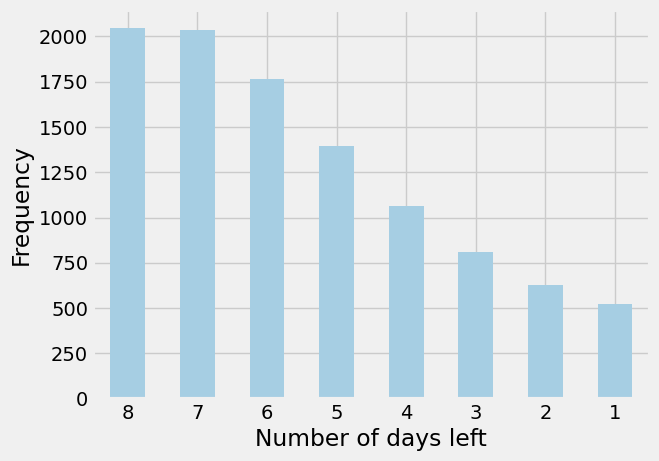

In [12]:
#@title Frequency plot of "days_left"
counts = df["days_left"].value_counts(sort=False).sort_index(inplace=False, ascending=False)
custom_counts = pd.Series(counts.values, index=list(range(8, 0, -1)))
ax = custom_counts.plot(kind="bar", colormap='Paired')

ax.set_ylabel("Frequency")
ax.set_xlabel("Number of days left")
ax.tick_params(axis='x', rotation=0)

plt.style.use("fivethirtyeight")

plt.savefig("images/d.svg")

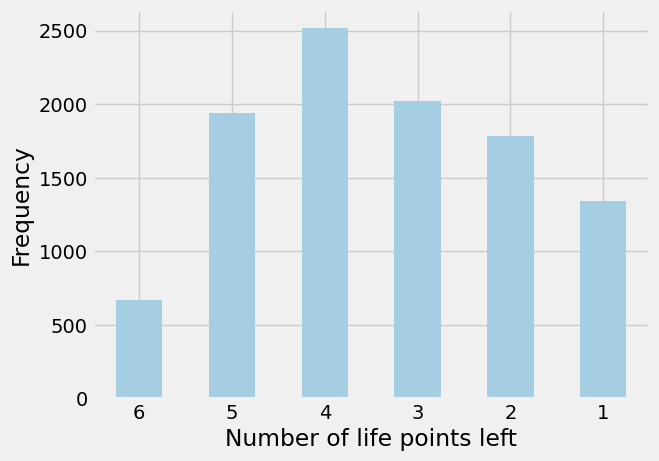

In [13]:
#@title Frequency plot of "life_points_left"
counts = df["life_points_left"].value_counts(sort=False).sort_index(inplace=False, ascending=False)
custom_counts = pd.Series(counts.values, index=list(range(6, 0, -1)))
ax = custom_counts.plot(kind="bar", colormap='Paired')

ax.set_ylabel("Frequency")
ax.set_xlabel("Number of life points left")
ax.tick_params(axis='x', rotation=0)

plt.savefig("images/lp.svg")

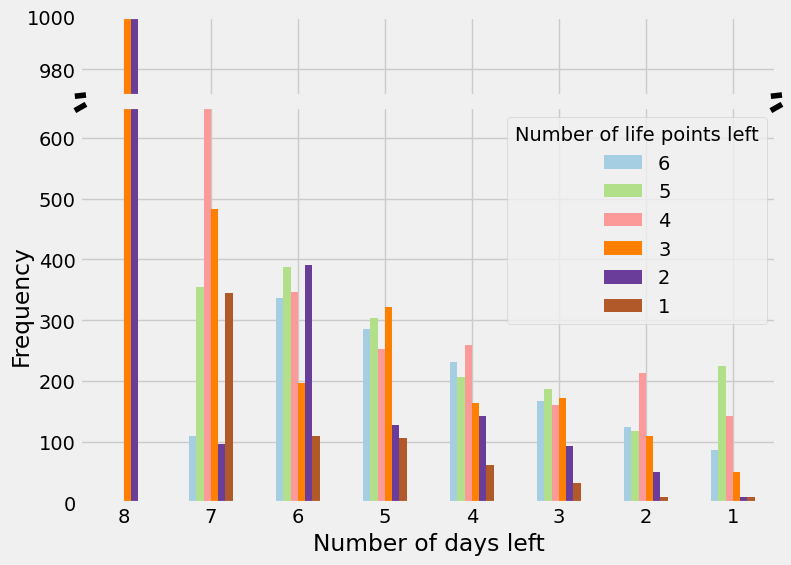

In [25]:
#@title Frequency plot of "days_left" along with "life_points_left"
counts = df.value_counts(["days_left", "life_points_left"], sort=False).unstack().sort_index(inplace=False, ascending=False)
custom_counts = pd.DataFrame(counts.values, index=list(range(8, 0, -1)), columns=list(range(6, 0, -1)))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [1, 5]})

ax1 = custom_counts.plot(kind="bar", ax=ax1, legend=False, colormap='Paired')
ax1.set_ylim(970, 1000)
ax1.tick_params(axis='x', bottom=False)

ax2 = custom_counts.plot(kind="bar", ax=ax2, legend=True, colormap='Paired')
ax2.set_ylim(0, 650)
ax2.set_ylabel("Frequency")
ax2.legend(title="Number of life points left", loc="upper right")

plt.xlabel("Number of days left")
plt.style.use("fivethirtyeight")
plt.subplots_adjust(hspace=0.05)

d = .008  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, zorder=100)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.tick_params(axis='x', rotation=0)

plt.savefig("images/d_lp.svg")

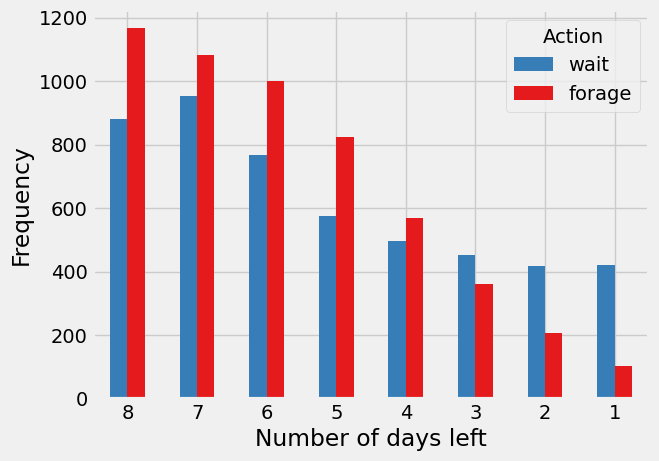

In [15]:
#@title Frequency plot of "days_left" for a particular "action"
counts = df.value_counts(["days_left", "action"], sort=False).unstack().sort_index(inplace=False, ascending=False)
custom_counts = pd.DataFrame(counts.values, index=list(range(8, 0, -1)), columns=["wait", "forage"])

color = plt.get_cmap("Set1").colors[:2][::-1]
ax = custom_counts.plot(kind="bar", color=color)

ax.set_xlabel("Number of days left")
ax.set_ylabel("Frequency")
ax.legend(title="Action", loc="upper right")

ax.tick_params(axis='x', rotation=0)

plt.savefig("images/d_a.svg")

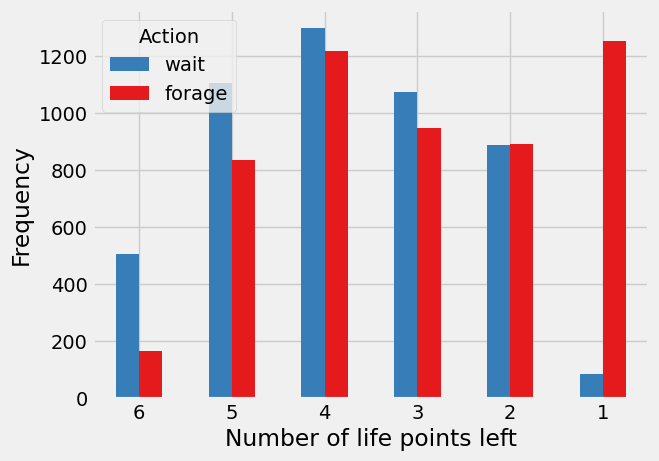

In [16]:
#@title Frequency plot of "life_points_left" for a particular "action"
counts = df.value_counts(["life_points_left", "action"], sort=False).unstack().sort_index(inplace=False, ascending=False)
custom_counts = pd.DataFrame(counts.values, index=list(range(6, 0, -1)), columns=["wait", "forage"])

color = plt.get_cmap("Set1").colors[:2][::-1]
ax = custom_counts.plot(kind="bar", color=color)

ax.set_xlabel("Number of life points left")
ax.set_ylabel("Frequency")
ax.legend(title="Action", loc="upper left")

ax.tick_params(axis='x', rotation=0)

plt.savefig("images/lp_a.svg")

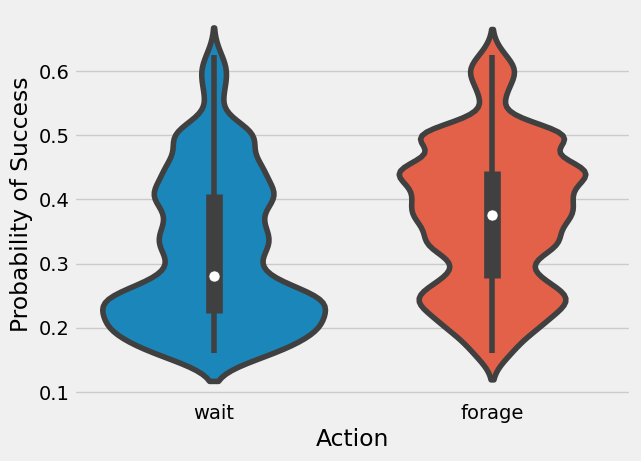

<Figure size 640x480 with 0 Axes>

In [17]:
#@title Box plot of "probability_success" for a particular "action"
sns.violinplot(x="action", y="probability_success", data=df)

plt.xlabel("Action")
plt.ylabel("Probability of Success")

plt.xticks(ticks=[0, 1], labels=["wait", "forage"])

plt.show()

plt.savefig("images/ps_a.svg")

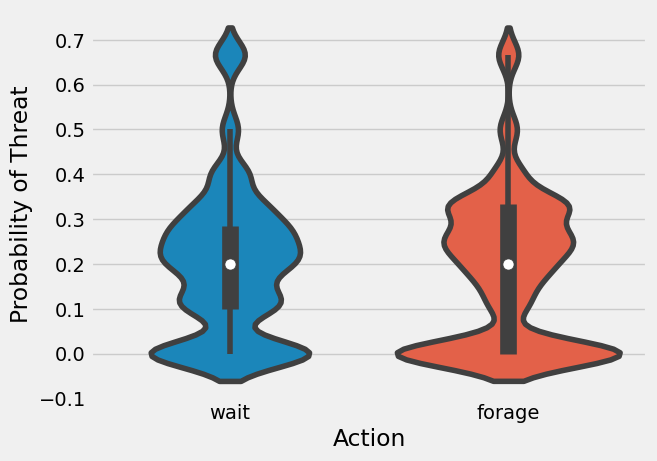

In [18]:
#@title Box plot of "probability_threat" for a particular "action"
sns.violinplot(x="action", y="probability_threat", data=df)

plt.xlabel("Action")
plt.ylabel("Probability of Threat")

plt.xticks(ticks=[0, 1], labels=["wait", "forage"])

plt.savefig("images/pt_a.svg")

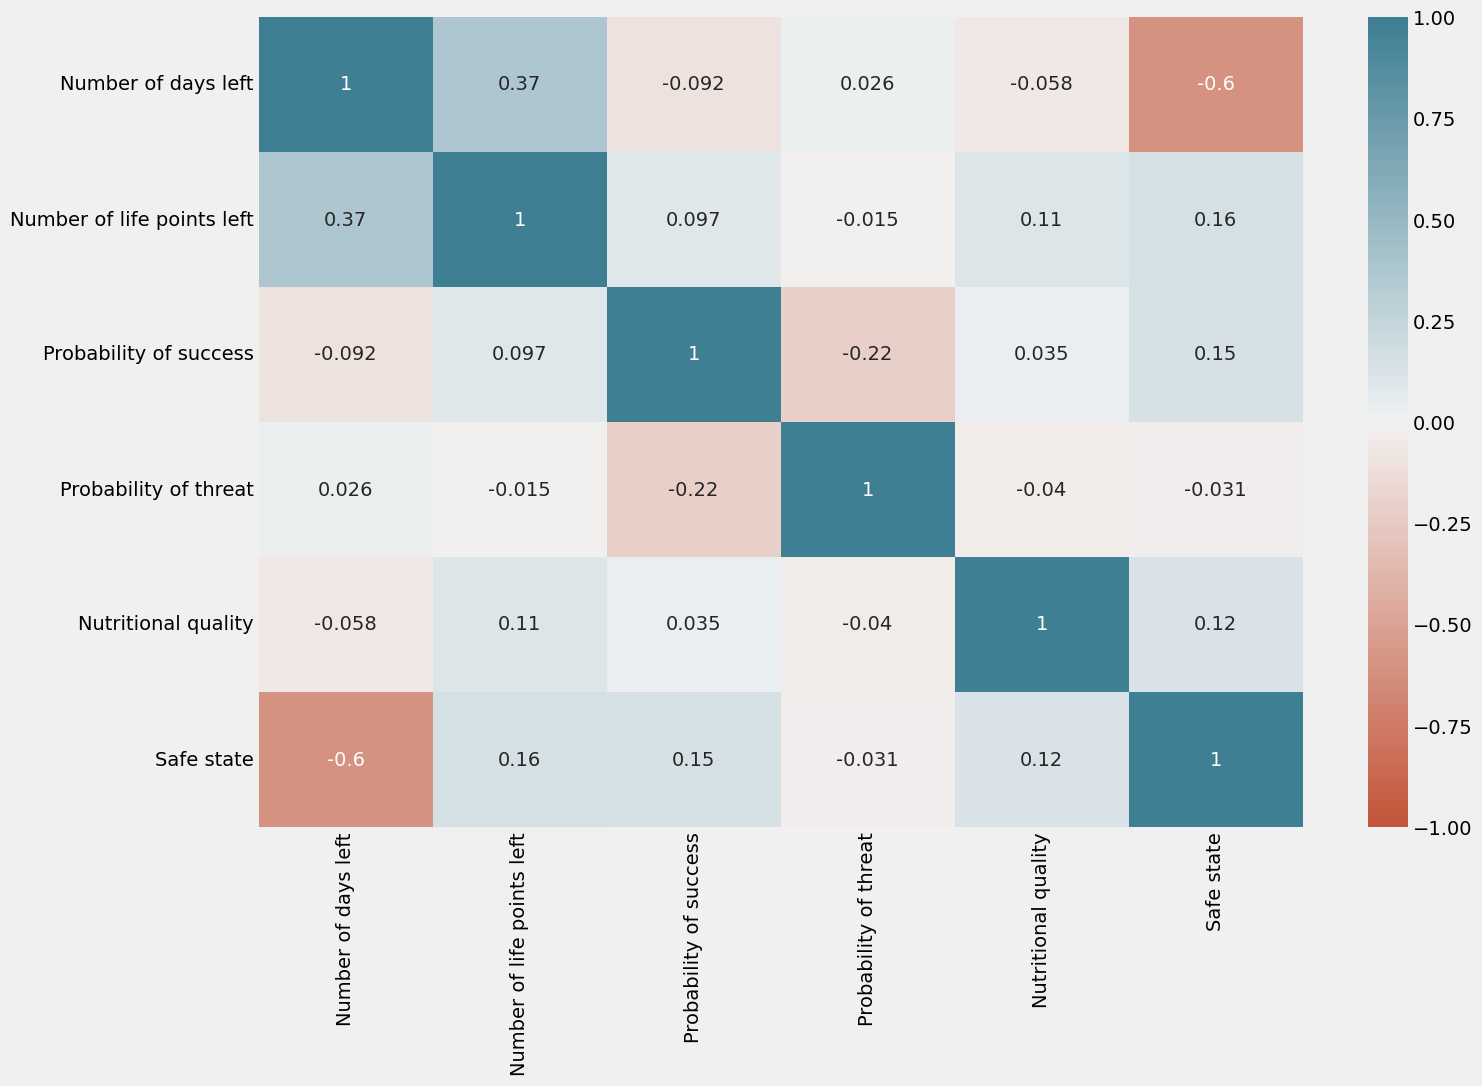

In [19]:
#@title Check correlation
names = ['Number of days left', 'Number of life points left', 'Probability of success',
       'Probability of threat', 'Nutritional quality', 'Safe state']

corr = df.drop("action", axis=1).corr()
corr = corr.set_axis(names, axis='columns', copy=False)
corr = corr.set_axis(names, axis='index', copy=False)

plt.figure(figsize=(15,10))
sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200)
)


plt.savefig("images/corr.svg")

In [20]:
#@title Training-validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [21]:
#@title Print shape
X_train.shape, X_test.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


((8216, 6), (2054, 6))

In [22]:
#@title Train interpretable decision tree
clf = DecisionTreeClassifier(
    max_depth=5,
    criterion="entropy",
    min_weight_fraction_leaf=0.05,
    min_impurity_decrease=0.02,
    random_state=42,
)

clf = clf.fit(X_train, y_train)

print(
    f"validation accuracy: {clf.score(X_test, y_test):.3f}, validation roc_auc score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]):.3f}"
)

validation accuracy: 0.748, validation roc_auc score: 0.796


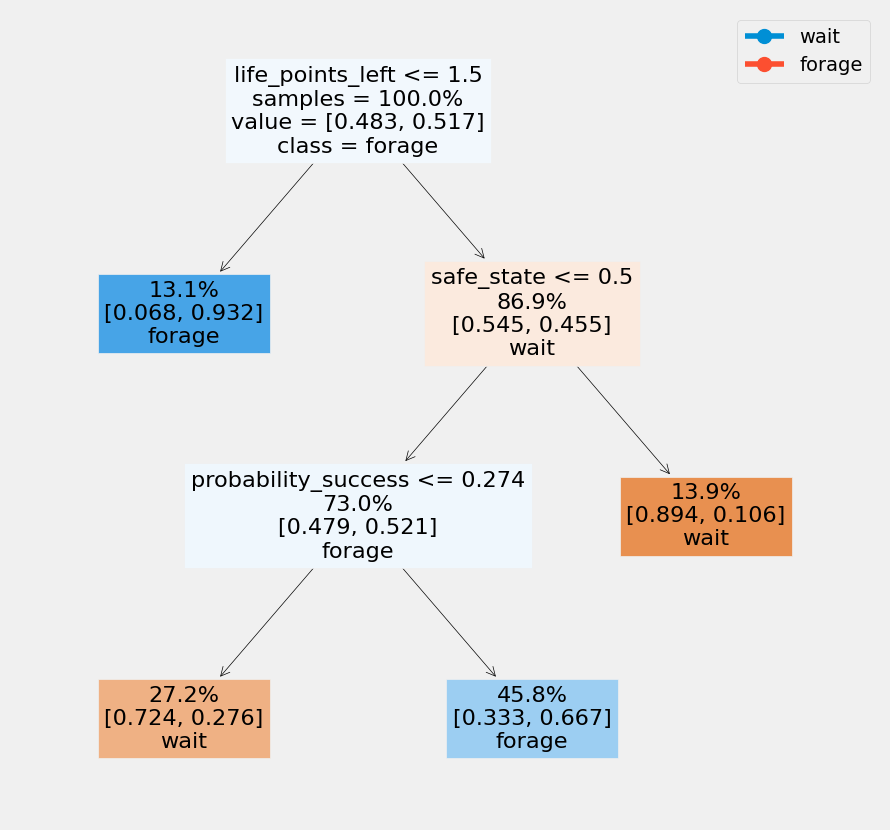

In [23]:
#@title Visualize tree
fig = plt.figure(figsize=(10, 10))
_ = tree.plot_tree(
    clf,
    feature_names=feature_names,
    class_names=target_names,
    impurity=False,
    label="root",
    proportion=True,
    filled=True
)

# Get the colors used in the tree plot
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a custom legend with colors and labels
custom_legend = [plt.Line2D([], [], color=colors[i], marker='o', markersize=10, label=label)
                 for i, label in enumerate(target_names)]
plt.legend(handles=custom_legend, loc='upper right')

plt.savefig("images/dt.svg")

# 4. Solve the foraging task

In [24]:
#@title evaluate algorithm (decision tree)

def preproc(obs):
    return np.array([[
        obs["days_left"],
        obs["life_points_left"],
        obs["environment"][0] * (1 - obs["environment"][1]),
        obs["environment"][1],
        obs["environment"][2],
        int(obs["life_points_left"] > obs["days_left"])]],
        dtype="float"
    )

num_episodes = 10000
episode_rewards = []

for episode in range(num_episodes):
    done = False
    obs, info = env.reset()

    total_reward = 0

    while not done:
        action = clf.predict(preproc(obs))[0]
        action = np.random.choice(
            [0, 1],
            p=clf.predict_proba(preproc(obs))[0]
        )
        obs, reward, done, _, info = env.step(action)

        total_reward += reward

    episode_rewards.append(total_reward)

episode_rewards = np.array(episode_rewards)

def print_metrics(episode_rewards):
    num_intervals = 100
    interval_size = num_episodes // num_intervals

    means = []
    std_devs = []

    for i in range(0, num_episodes, interval_size):
        interval_data = episode_rewards[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (1 + np.mean(episode_rewards, axis=0)) * 100
    std_dev = np.std(std_devs, axis=0) * 100

    return avg, std_dev

avg, std_dev = print_metrics(episode_rewards)

print(f"survival rate (in %): {avg:.1f} +- {std_dev:.3f}")

survival rate (in %): 19.3 +- 5.965
